[GDL](https://github.com/davidADSP/GDL_code/blob/tensorflow_2/models/VAE.py)

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, ReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping, CSVLogger
from keras.utils import plot_model
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [12]:
K.clear_session()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
from tensorflow.keras.datasets import mnist
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

trainX=trainX/255
testX=testX/255

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [8]:
class AutoEncoder():

    _ENC_FILTERS = [32,64,64,64]
    _ENC_STRIDES = [1,2,2,1]
    _FILTER_SIZE = [3,3,3,3]
    _LATENT_SPACE = 32
    _DEC_FILTERS = [64,64,32,1]
    _DEC_STRIDES = [1,2,2,1]
    _BATCH_NORM = True
    _DROPOUT = 0.2

    def __init__(self,input_dim, latent_space):

        self.input_dim = input_dim
        self.latent = latent_space

    def _build_encoder(self):

        encoder_input = Input(shape=self.input_dim,name='encoder_input')
        x=encoder_input

        for lyr in range(len(self._ENC_FILTERS)):

            conv_layer = Conv2D(filters = self._ENC_FILTERS[lyr],
                              kernel_size = self._FILTER_SIZE[lyr],
                              strides = self._ENC_STRIDES[lyr],
                              name = 'encoder_conv'+str(lyr),
                              padding ='same')
            x = conv_layer(x)
            x = ReLU()(x)

            if self._BATCH_NORM == True:
                x = BatchNormalization()(x)

        shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        encoder_output = Dense(self.latent, name = 'encoder_output')(x)
        encoder = Model(encoder_input, encoder_output, name = 'Encoder')

        return encoder

    def _build_decoder(self,shape_before_flattening):

        decoder_input = Input(shape = self.latent,name = 'decoder_input')
        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for lyr in range(len(self._DEC_FILTERS)):

            conv_t_layer = Conv2DTranspose(filters = self._DEC_FILTERS[lyr],
                                         kernel_size = self._FILTER_SIZE[lyr],
                                         strides=self._DEC_STRIDES[lyr],
                                         name = 'decoder_conv_t'+str(lyr),
                                         padding = 'same')
            x = conv_t_layer(x)

            if lyr<len(self._DEC_FILTERS)-1:

                x = ReLU()(x)

                if self._BATCH_NORM == True:
                    x = BatchNormalization()(x)
            else:
                x=Activation('sigmoid')(x)

        decoder_output = x
        decoder = Model(decoder_input,decoder_output, name = 'Decoder')
        return decoder

    def fit(self,Xtr,Xval,**kwargs):

        self.initial_lr = kwargs.get("initial_lr", 0.001)
        self.batch_size = kwargs.get("batch_size", 32)
        self.callbacks_list = kwargs.get("callbacks_list", [])
        self.epochs = kwargs.get("epochs", 100)
        self.shuffle = kwargs.get("shuffle", True)

        model, decoder, encoder = self.get_model()

        model.fit(Xtr, Xtr,
                       batch_size = self.batch_size,
                       validation_data = (Xval,Xval),
                       shuffle = self.shuffle,
                       epochs = self.epochs,
                       callbacks = self.callbacks_list)

        self.model = model
        self.decoder = decoder
        self.encoder = encoder

    def get_model(self):

        #Autoencoder Layer
        encoder = self._build_encoder()
        shape_before_flattening = encoder.layers[-5].get_output_at(0).get_shape().as_list()[1:]
        decoder = self._build_decoder(shape_before_flattening)

        model_input = Input(shape=self.input_dim,name = 'encoder_input')
        encoder_op = encoder(model_input)
        decoder_op = decoder(encoder_op)

        model = Model(model_input,decoder_op,name = 'ae_model')

        model.compile(optimizer = Adam(learning_rate  = 0.001),
                           loss = 'mean_squared_error')

        return model, decoder, encoder

In [9]:
ae = AutoEncoder(input_dim=(28,28,1), latent_space = 16)
model, decoder, encoder = ae.get_model()
model.summary()

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 16)                143760    
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         146561    
                                                                 
Total params: 290,321
Trainable params: 289,553
Non-trainable params: 768
_________________________________________________________________


In [10]:
log_path = './artefacts/logs/'
model_path =  './artefacts/model/'

In [13]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)
checkpoint= ModelCheckpoint(model_path+'ae_weights.h5', save_weights_only = True, verbose=1)
csv_logger = CSVLogger(log_path+'ae_training.csv')


callbacks_list=[early_stopper, checkpoint,csv_logger]
ae.fit(trainX,testX, epochs = 100, batch_size = 16, callbacks_list = callbacks_list)

Epoch 1/100
3749/3750 [============================>.] - ETA: 0s - loss: 0.0159
Epoch 1: saving model to ./artefacts/model\ae_weights.h5
3750/3750 [==============================] - 67s 17ms/step - loss: 0.0159 - val_loss: 0.0099
Epoch 2/100
3748/3750 [============================>.] - ETA: 0s - loss: 0.0089
Epoch 2: saving model to ./artefacts/model\ae_weights.h5
3750/3750 [==============================] - 68s 18ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 3/100
3747/3750 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 3: saving model to ./artefacts/model\ae_weights.h5
3750/3750 [==============================] - 64s 17ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 4/100
3747/3750 [============================>.] - ETA: 0s - loss: 0.0073
Epoch 4: saving model to ./artefacts/model\ae_weights.h5
3750/3750 [==============================] - 63s 17ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 5/100
3748/3750 [============================>.] - ETA: 0s - loss: 0.0069


1/1 [==============================] - 1s 837ms/step


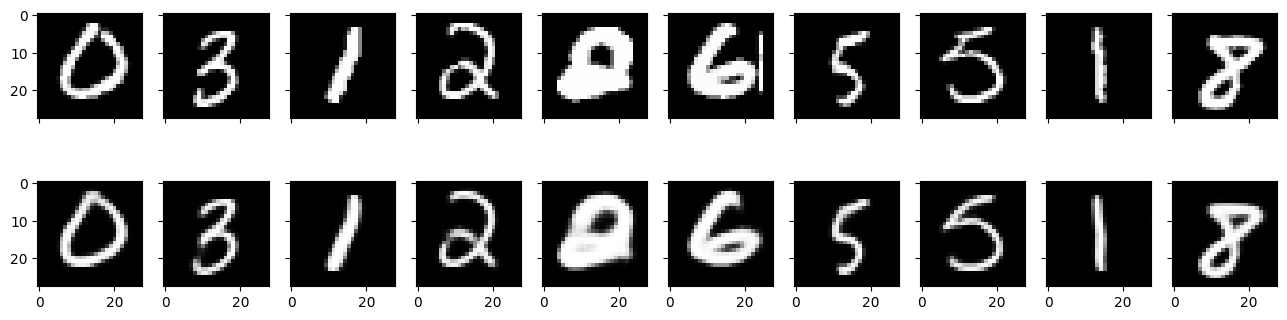

In [15]:
samples = np.random.randint(0,testX.shape[0],10)
testX_recons = ae.model.predict(testX[samples])

fig,axn=plt.subplots(2,10,sharex='col',sharey='row',figsize=(16,4))
for n,i in enumerate(samples):
    axn[0,n].imshow(testX[i], cmap = 'gray')
    axn[1,n].imshow(testX_recons[n],cmap = 'gray')